# Token-Level Decomposition: Applicability Analysis

The `TokenDecompose` algorithm (in `transduction/token_decompose.py`) is a **specialized optimization** for FSTs where the input projection accepts $\Sigma^*$ — a property called `all_input_universal`. This notebook explains the property, demonstrates which FSTs satisfy it, and characterizes the boundary.

In [ ]:
import sys; sys.path.insert(0, '..')
from IPython.display import display, HTML, Markdown
from transduction import examples
from transduction.fst import FST, EPSILON
from transduction.universality import check_all_input_universal
from transduction.token_decompose import TokenDecompose, extract_token_bytes, build_trie
from transduction.util import display_table

## 1. What is `all_input_universal`?

An FST maps input strings to output strings. Its **input projection** is the FSA you get by ignoring all output labels — it describes what inputs the FST *accepts*.

An FST is `all_input_universal` when its input projection accepts $\Sigma^*$ (every possible input string over the input alphabet). Formally, the check verifies:

1. The $\varepsilon$-closed start set contains a final state
2. The start set is **complete** (has arcs for every input symbol)
3. Every symbol's successor $\varepsilon$-closure **contains** the start set

Condition (3) is the key insight: if every successor contains the start set, then by induction *all* reachable DFA states of the input projection contain the start set, so they're all final and complete. Hence: universal.

## 2. Why does it matter for decomposition?

In the generic decomposition BFS, for each new DFA state we must run an expensive **universality sub-BFS** to determine if that state accepts $\Sigma^*$. This is the bottleneck.

When `all_input_universal` is true, *every* final DFA state is automatically universal — the sub-BFS can be skipped entirely. Furthermore, the DFA states can be represented as **position subsets** $\{0, \ldots, |\text{target}|\}$ instead of NFA-state subsets, yielding $O(N)$ states instead of $O(|Q_{\text{FST}}| \times N)$.

## 3. Survey of all test FSTs

Let's check which of our test FSTs satisfy the property:

In [2]:
test_fsts = [
    ('replace',          examples.replace([('1','a'),('2','b'),('3','c'),('4','d'),('5','e')])),
    ('delete_b',         examples.delete_b()),
    ('weird_copy',       examples.weird_copy()),
    ('duplicate',        examples.duplicate(set('12345'))),
    ('triplets_of_doom', examples.triplets_of_doom()),
    ('parity',           examples.parity({'a','b'})),
    ('samuel',           examples.samuel_example()),
    ('small',            examples.small()),
    ('sdd1',             examples.sdd1_fst()),
    ('number_comma_sep', examples.number_comma_separator({'a',',',' ','0'}, Digit={'0'})),
    ('newspeak2',        examples.newspeak2()),
    ('lookahead',        examples.lookahead()),
    ('infinite_quot',    examples.infinite_quotient()),
]

rows = []
for name, fst in test_fsts:
    aiu = check_all_input_universal(fst)
    n = len(list(fst.states))
    mark = '\u2705' if aiu else '\u274c'
    rows.append([f'<code>{name}</code>', n, f'{mark} {aiu}'])

display_table(rows, headings=['Name', 'States', 'all_input_universal'])

Name,States,all_input_universal
<code>replace</code>,1,✅ True
<code>delete_b</code>,1,✅ True
<code>weird_copy</code>,3,✅ True
<code>duplicate</code>,6,✅ True
<code>triplets_of_doom</code>,5,❌ False
<code>parity</code>,3,❌ False
<code>samuel</code>,5,❌ False
<code>small</code>,4,❌ False
<code>sdd1</code>,3,❌ False
<code>number_comma_sep</code>,3,❌ False


Only 4 out of 13 test FSTs qualify: **replace**, **delete_b**, **weird_copy**, and **duplicate**. Let's examine why each group passes or fails.

## 4. Examples that satisfy `all_input_universal`

### 4.1 Simple substitution (replace)

A 1-state FST with a self-loop for every input symbol. Classic BPE tokenizers have this structure.

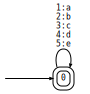

`all_input_universal`: **True** — single hub state, every input loops back to it. This is the prototypical BPE tokenizer shape.

In [3]:
fst_replace = examples.replace([('1', 'a'), ('2', 'b'), ('3', 'c'), ('4', 'd'), ('5', 'e')])
display(fst_replace)
display(Markdown(f'`all_input_universal`: **{check_all_input_universal(fst_replace)}** — '
                 f'single hub state, every input loops back to it. '
                 f'This is the prototypical BPE tokenizer shape.'))

### 4.2 Delete-b

Deletes every `b` and replaces `a` $\to$ `A`. The key: it has arcs for *both* input symbols, so it's complete. Even though `b` $\to\varepsilon$ (deletion), the input symbol `b` is still consumed.

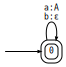

`all_input_universal`: **True** — input projection accepts {a,b}*

In [4]:
fst_del = examples.delete_b()
display(fst_del)
display(Markdown(f'`all_input_universal`: **{check_all_input_universal(fst_del)}** — '
                 f'input projection accepts {{a,b}}*'))

### 4.3 Weird copy (with $\varepsilon$-loops)

A copy transducer where intermediate states use $\varepsilon$-transitions to return to the start. States 1 and 2 have no input arcs — but the $\varepsilon$-closure of the successors from state 0 includes state 0 itself, so the check passes.

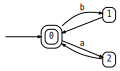

`all_input_universal`: **True** — the property is about the **$\varepsilon$-closed** input projection, not the raw arcs

In [5]:
fst_wc = examples.weird_copy()
display(fst_wc)
display(Markdown(f'`all_input_universal`: **{check_all_input_universal(fst_wc)}** — '
                 f'the property is about the **$\\varepsilon$-closed** input projection, not the raw arcs'))

### 4.4 Duplicate

Repeats each input symbol K times (default K=2). Each token consumes one input symbol and produces K output symbols via an $\varepsilon$-input chain that returns to the hub.

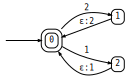

`all_input_universal`: **True** — each input symbol leads into a $\varepsilon$-input chain that emits the symbol K times, then returns to the hub

In [6]:
fst_dup = examples.duplicate(set('12'))
display(fst_dup)
display(Markdown(f'`all_input_universal`: **{check_all_input_universal(fst_dup)}** — '
                 f'each input symbol leads into a $\\varepsilon$-input chain that emits the symbol K times, '
                 f'then returns to the hub'))

### Common pattern

All four qualifying FSTs share a **hub structure**: a single start/final state (or $\varepsilon$-equivalent set) that is complete on the input alphabet, where every successor $\varepsilon$-closes back to include the hub.

## 5. Counterexamples: FSTs that fail `all_input_universal`

### 5.1 Triplets of doom — successors don't return to start

Copies strings of the form $(a^3 | b^3)^*$. Every state has an arc, but only for *one* symbol.

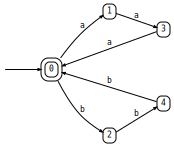

`all_input_universal`: **False**

Start = {0}. On `a`: successor = {1}. $\varepsilon$-close({1}) = {1}.  
Does {1} $\supseteq$ {0}? **No.** Condition 3 fails.  
The FST only accepts $(aaa|bbb)^*$ — it rejects `ab`.

In [7]:
fst_trip = examples.triplets_of_doom()
display(fst_trip)
display(Markdown(
    f'`all_input_universal`: **{check_all_input_universal(fst_trip)}**\n\n'
    f'Start = {{0}}. On `a`: successor = {{1}}. $\\varepsilon$-close({{1}}) = {{1}}.  \n'
    f'Does {{1}} $\\supseteq$ {{0}}? **No.** Condition 3 fails.  \n'
    f'The FST only accepts $(aaa|bbb)^*$ — it rejects `ab`.'
))

### 5.2 Parity — successor doesn't contain start set

Outputs `1` if input length is even, `0` if odd. Both states are complete on `{a,b}`, but they *cycle* rather than returning to the start set.

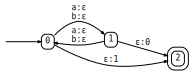

`all_input_universal`: **False**

Start = {0}. $\varepsilon$-close({0}) = {0, 2} (via $\varepsilon$/`1` to state 2).  
On `a`: raw successor = {1}. $\varepsilon$-close({1}) = {1, 2} (via $\varepsilon$/`0` to 2).  
Does {1, 2} $\supseteq$ {0, 2}? **No** — missing state 0.  

> **Note:** The input projection *does* accept $\Sigma^*$, but the sufficient condition in `check_all_input_universal` is too conservative to detect it. This is a **false negative** of the $O(N)$ check.

In [8]:
fst_par = examples.parity({'a', 'b'})
display(fst_par)
display(Markdown(
    f'`all_input_universal`: **{check_all_input_universal(fst_par)}**\n\n'
    f'Start = {{0}}. $\\varepsilon$-close({{0}}) = {{0, 2}} (via $\\varepsilon$/`1` to state 2).  \n'
    f'On `a`: raw successor = {{1}}. $\\varepsilon$-close({{1}}) = {{1, 2}} (via $\\varepsilon$/`0` to 2).  \n'
    f'Does {{1, 2}} $\\supseteq$ {{0, 2}}? **No** — missing state 0.  \n\n'
    f'> **Note:** The input projection *does* accept $\\Sigma^*$, '
    f'but the sufficient condition in `check_all_input_universal` is too conservative to detect it. '
    f'This is a **false negative** of the $O(N)$ check.'
))

### 5.3 Small — dead-end state

State 1 is final but has **no outgoing arcs**. After reading a single `a`, the FST is stuck.

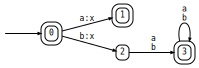

`all_input_universal`: **False** — state 1 is a dead end with no outgoing arcs

In [9]:
fst_small = examples.small()
display(fst_small)
display(Markdown(
    f'`all_input_universal`: **{check_all_input_universal(fst_small)}** — '
    f'state 1 is a dead end with no outgoing arcs'
))

### 5.4 Lookahead — incomplete state

The FST uses $\varepsilon$-output to peek at future input, creating states that are not complete on the input alphabet.

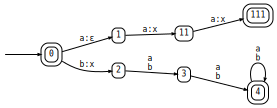

`all_input_universal`: **False** — state 1 only accepts `a`, not `b`

In [10]:
fst_la = examples.lookahead()
display(fst_la)
display(Markdown(
    f'`all_input_universal`: **{check_all_input_universal(fst_la)}** — '
    f'state 1 only accepts `a`, not `b`'
))

### 5.5 Newspeak2 — context matching with partial states

The `bad` $\to$ `ungood` replacement requires matching a 3-character context. Intermediate states only have arcs for specific symbols.

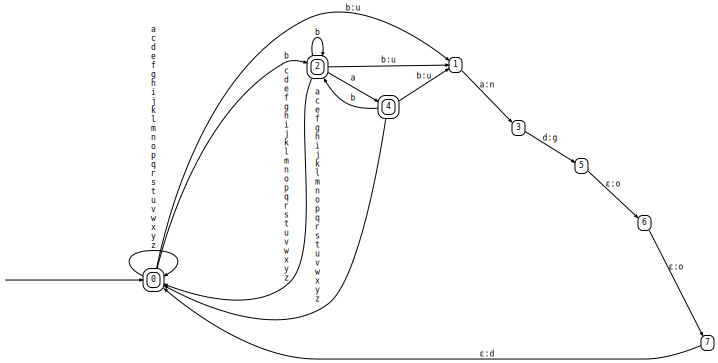

`all_input_universal`: **False** — states 1, 3, 5 are context-matching states with only one outgoing arc each

In [11]:
fst_ns = examples.newspeak2()
display(fst_ns)
display(Markdown(
    f'`all_input_universal`: **{check_all_input_universal(fst_ns)}** — '
    f'states 1, 3, 5 are context-matching states with only one outgoing arc each'
))

### 5.6 Infinite quotient — absorbing region

After seeing separator `#`, the FST enters an absorbing state. The successor on `#` doesn't $\varepsilon$-close back to the start set.

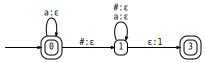

`all_input_universal`: **False** — successor on `#` enters an absorbing region that doesn't contain the start set

In [12]:
fst_iq = examples.infinite_quotient()
display(fst_iq)
display(Markdown(
    f'`all_input_universal`: **{check_all_input_universal(fst_iq)}** — '
    f'successor on `#` enters an absorbing region that doesn\'t contain the start set'
))

## 6. Token extraction and trie compilation

`TokenDecompose` doesn't just need `all_input_universal` — it also assumes a specific **hub structure** where tokens can be extracted as `(token_id, byte_sequence)` pairs. `extract_token_bytes` assumes:

1. Start states have non-$\varepsilon$ input arcs (the "token ID")
2. Each such arc leads into a chain of $\varepsilon$-input arcs (the "byte/output sequence")
3. The chain returns to a start state

This is exactly the structure of a BPE tokenizer FST. The extracted tokens then compile into a `ByteTrie` for fast prefix matching during the BFS. Green nodes in the trie indicate token completions; edges are labeled with output bytes.

Note: tokens with empty output (e.g., `delete_b`'s `'b' -> ()`) are handled as zero-length tokens (self-loops in the DFA) and don't appear in the trie.

### replace

token_id,output_bytes
<code>'1'</code>,"<code>('a',)</code>"
<code>'2'</code>,"<code>('b',)</code>"
<code>'3'</code>,"<code>('c',)</code>"
<code>'4'</code>,"<code>('d',)</code>"
<code>'5'</code>,"<code>('e',)</code>"


`ByteTrie` (6 nodes):

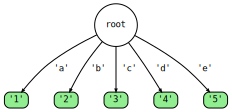

### delete_b

token_id,output_bytes
<code>'a'</code>,"<code>('A',)</code>"
<code>'b'</code>,<code>()</code>


`ByteTrie` (2 nodes):

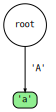

### weird_copy

token_id,output_bytes
<code>'b'</code>,"<code>('b',)</code>"
<code>'a'</code>,"<code>('a',)</code>"


`ByteTrie` (3 nodes):

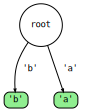

### duplicate

token_id,output_bytes
<code>'2'</code>,"<code>('2', '2')</code>"
<code>'5'</code>,"<code>('5', '5')</code>"
<code>'1'</code>,"<code>('1', '1')</code>"
<code>'3'</code>,"<code>('3', '3')</code>"
<code>'4'</code>,"<code>('4', '4')</code>"


`ByteTrie` (11 nodes):

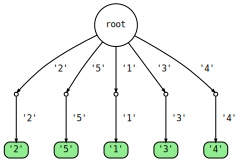

In [13]:
token_examples = [
    ('replace',    examples.replace([('1','a'),('2','b'),('3','c'),('4','d'),('5','e')])),
    ('delete_b',   examples.delete_b()),
    ('weird_copy', examples.weird_copy()),
    ('duplicate',  examples.duplicate(set('12345'))),
]

for name, fst in token_examples:
    tokens = extract_token_bytes(fst)
    rows = [[f'<code>{tid!r}</code>', f'<code>{bseq}</code>'] for tid, bseq in tokens]
    trie = build_trie(fst)
    display(Markdown(f'### {name}'))
    display_table(rows, headings=['token_id', 'output_bytes'])
    display(Markdown(f'`ByteTrie` ({len(trie.children)} nodes):'))
    display(trie)

## 7. TokenDecompose in action

For qualifying FSTs, `TokenDecompose` produces quotient and remainder FSAs with $O(N)$ states:

**FST (replace):**

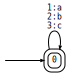

**Decomposition for target = `[a, b]`:**

Quotient (Q),Remainder (R)
"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- start --> start <!-- 0 --> 0 frozenset({0}) <!-- start->0 --> start->0 <!-- 2 --> 2 frozenset({1}) <!-- 0->2 --> 0->2 1 <!-- 1 --> 1 frozenset({2}) <!-- 2->1 --> 2->1 2",∅


In [14]:
fst = examples.replace([('1', 'a'), ('2', 'b'), ('3', 'c')])
display(Markdown('**FST (replace):**'))
display(fst)

td = TokenDecompose(fst, ['a', 'b'])
display(Markdown('**Decomposition for target = `[a, b]`:**'))
display_table(
    [[td.quotient.trim(), td.remainder.trim()]],
    headings=['Quotient (Q)', 'Remainder (R)'],
)

**FST (delete_b):**

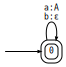

**Decomposition for target = `[A]`:**

Quotient (Q),Remainder (R)
"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- start --> start <!-- 0 --> 0 frozenset({0}) <!-- start->0 --> start->0 <!-- 0->0 --> 0->0 b <!-- 1 --> 1 frozenset({1}) <!-- 0->1 --> 0->1 a",∅


In [15]:
fst = examples.delete_b()
display(Markdown('**FST (delete_b):**'))
display(fst)

td = TokenDecompose(fst, ['A'])
display(Markdown('**Decomposition for target = `[A]`:**'))
display_table(
    [[td.quotient.trim(), td.remainder.trim()]],
    headings=['Quotient (Q)', 'Remainder (R)'],
)

## 8. Characterization

### When does `all_input_universal` hold?

**Sufficient conditions** (the check verifies these):

1. **Single hub state**: One state that is start, final, and the target of all transitions. Every input symbol has a self-loop. *(replace, delete_b)*

2. **Hub with $\varepsilon$-return**: The hub state has arcs for all input symbols. Intermediate states only have $\varepsilon$-input arcs returning to the hub. *(weird_copy, duplicate)*

**What the check does NOT detect** (false negatives):

- **Cycling state sets**: If states A and B are both complete and cycle between each other, the input projection may be universal, but the successors' $\varepsilon$-closures don't contain each other's start sets. *(parity is this case)*

### When does it fail?

| Failure mode | Example | Why |
|---|---|---|
| **Dead-end states** | `small` | State 1 has no outgoing arcs |
| **Incomplete states** | `lookahead`, `newspeak2` | Context-matching states only accept specific symbols |
| **Non-returning successors** | `triplets_of_doom`, `infinite_quotient` | Successors don't $\varepsilon$-close back to include start set |
| **Conservative check** | `parity` | Input projection *is* universal, but cycling structure defeats the $O(N)$ check |

In practice, any FST that does **context-dependent** processing (lookahead, pattern matching, state-tracking) will fail, because intermediate states involved in context tracking are necessarily incomplete.

## 9. Could `TokenDecompose` be generalized?

The core idea — DFA states as position subsets rather than NFA-state subsets — relies on the fact that **all FST states behave identically** for universality purposes. When `all_input_universal` is true, the FST state doesn't matter — only the buffer position matters.

Potential generalizations:

| Idea | Feasibility | Notes |
|------|------------|-------|
| **Stronger universality check** | Easy | A full DFA-based check could detect cases like `parity`. Trade-off: $O(N^2)$ vs $O(N)$. |
| **Per-state universality** | Moderate | Use `compute_ip_universal_states()` to identify which FST states are universal. Only track FST state for non-universal states. |
| **Partial hub detection** | Hard | Some FSTs have a hub subgraph with non-hub spurs. Could use token decomp for the hub portion. |
| **Lazy position tracking** | Easy | Even for non-universal FSTs, position subsets could replace NFA-state subsets for the *universal* portion of the state space. |

The most promising near-term improvement is a **stronger universality check** that handles the cycling case (parity). Beyond that, **per-state universality** could enable a hybrid approach for FSTs where most states are universal but a few aren't.

## 10. Summary

| Property | Description |
|----------|------------|
| **What** | `all_input_universal` means the input projection of the FST accepts $\Sigma^*$ |
| **When (detected)** | Hub-structured FSTs: BPE tokenizers, simple substitution, deletion, copy-with-$\varepsilon$-return |
| **False negatives** | Cycling universal FSTs (e.g., parity) where successors don't contain the start set |
| **Not when** | Context-dependent FSTs: lookahead, pattern matching, incomplete states, dead-end states |
| **Why it helps** | Universality check is free (always true), DFA states are $O(N)$ position subsets |
| **Extra assumption** | `extract_token_bytes` requires hub structure with $\varepsilon$-input return chains |